In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#!unrar e "/content/gdrive/My Drive/Colab Notebooks/vocals2song/dataset/input2.rar" "/content/gdrive/My Drive/Colab Notebooks/vocals2song/dataset/input/"

In [0]:
#!unrar e "/content/gdrive/My Drive/Colab Notebooks/vocals2song/dataset/output2.rar" "/content/gdrive/My Drive/Colab Notebooks/vocals2song/dataset/output/"

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
  print('Installed the version 2.x of Tensorflow')
except Exception:
  print('Tensorflow 2.x not found')
  pass
import tensorflow as tf

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd

TensorFlow 2.x selected.
Installed the version 2.x of Tensorflow


In [0]:
# Ruta Raiz.
PATH = '/content/gdrive/My Drive/Colab Notebooks/vocals2song/dataset'

# Data input.
INPATH = PATH + '/input'

# Data target.
OUTPATH = PATH + '/output'

# Checkpoints path.
CKPATH = PATH + '/checkpoints'

# Number of channels.
NCHANNELS = 3

imgurls = !ls -1 '{INPATH}'

n = 50
train_n = round(n*0.85)

#listado randomizado.
randurls = np.copy(imgurls)

np.random.seed(42)
np.random.shuffle(randurls)

# Particion train/test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))

2272 42 8


In [0]:
print(tr_urls)

['00188.bmp' '01803.bmp' '02119.bmp' '01089.bmp' '01379.bmp' '00680.bmp'
 '00548.bmp' '01055.bmp' '01116.bmp' '00582.bmp' '00471.bmp' '01920.bmp'
 '02118.bmp' '00290.bmp' '00298.bmp' '01840.bmp' '01838.bmp' '00856.bmp'
 '00259.bmp' '01318.bmp' '00426.bmp' '01104.bmp' '01743.bmp' '01561.bmp'
 '00029.bmp' '01285.bmp' '01956.bmp' '00993.bmp' '02081.bmp' '02028.bmp'
 '00100.bmp' '00367.bmp' '02258.bmp' '00254.bmp' '01879.bmp' '02112.bmp'
 '00522.bmp' '01575.bmp' '02168.bmp' '01958.bmp' '01273.bmp' '01738.bmp']


In [0]:
len(tr_urls)

42

In [0]:
tr_urls = np.append(tr_urls, ['01621.bmp', '01619.bmp', '00178.bmp','00180.bmp','01960.bmp','01961.bmp',
                             '01625.bmp', '01615.bmp', '00181.bmp','00182.bmp','01959.bmp','01962.bmp',
                             '01630.bmp', '01631.bmp', '00183.bmp','00184.bmp','01963.bmp','01964.bmp',
                             '01632.bmp', '01633.bmp', '00185.bmp','00186.bmp','01965.bmp','01966.bmp'])

In [0]:
print(ts_urls)

['01620.bmp' '00179.bmp' '00727.bmp' '01508.bmp' '00056.bmp' '00282.bmp'
 '00457.bmp' '01961.bmp']


In [0]:
IMG_WIDTH = 2048
IMG_HEIGHT = 512

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  # 127.5
  input_image = (input_image / (255/2)) - 1
  real_image = (real_image / (255/2)) - 1

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, NCHANNELS])

  return cropped_image[0], cropped_image[1]


@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 268 x 268 x 3
  input_image, real_image = resize(input_image, real_image, 523, 2634)

  # randomly cropping to IMG_HEIGHT x IMG_WIDTH x NCHANNELS
  input_image, real_image = random_crop(input_image, real_image)

  return input_image, real_image

@tf.function()
def load_image(filename, augment=True):

  inimg = tf.cast(tf.image.decode_bmp(tf.io.read_file(INPATH + '/' + filename)), tf.float32)[..., :NCHANNELS]
  reimg = tf.cast(tf.io.decode_bmp(tf.io.read_file(OUTPATH + '/' + filename)), tf.float32)[..., :NCHANNELS]

  inimg, reimg = resize(inimg, reimg, IMG_HEIGHT, IMG_WIDTH)
  
  if augment:
     inimg, reimg = random_jitter(inimg, reimg)

  inimg, reimg = normalize(inimg, reimg)

  return inimg, reimg

def load_train_image(filename):
  return load_image(filename, False)

def load_test_image(filename):
  return load_image(filename, False)


In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(ts_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


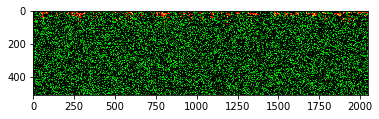

In [0]:
plt.imshow(load_train_image(randurls[0])[0])

In [0]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

In [0]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(Conv2D(filters,
                    size,
                    strides=2,
                    padding='same',
                    kernel_initializer=initializer,
                    use_bias=False))

  if apply_batchnorm:
    result.add(BatchNormalization())

  result.add(LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = Sequential()
  result.add(Conv2DTranspose(filters, 
                             size,
                             strides=2,
                             padding='same',
                             kernel_initializer=initializer,
                             use_bias=False))

  result.add(BatchNormalization())

  if apply_dropout:
      result.add(Dropout(0.5))

  result.add(ReLU())

  return result

In [0]:
def Generator():
  
  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]
# original shape = 2048 x 2048
#  down_stack = [
#    downsample(64, 4, apply_batchnorm=False), # (bs, 512, 512, 64)
#    downsample(128, 4), # (bs, 256, 256, 128)
#    downsample(256, 4), # (bs, 128, 128, 512)
#    downsample(512, 4), # (bs, 64, 64, 512)
#    downsample(512, 4), # (bs, 32, 32, 512)
#    downsample(512, 4), # (bs, 16, 16, 512)
#    downsample(512, 4), # (bs, 8, 8, 512)
#    downsample(512, 4), # (bs, 4, 4, 512)
#    downsample(512, 4), # (bs, 2, 2, 512)
#    downsample(512, 4), # (bs, 1, 1, 512)
#  ]#

#  up_stack = [
#    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
#    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
#    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
#    upsample(512, 4), # (bs, 16, 16, 1024)
#    upsample(256, 4), # (bs, 32, 32, 512)
#    upsample(128, 4), # (bs, 64, 64, 256)
#    upsample(64, 4), # (bs, 128, 128, 128)
#    upsample(64, 4), # (bs, 256, 256, 128)
#    upsample(64, 4), # (bs, 512, 512, 128)
#  ]


  initializer = tf.random_normal_initializer(0., 0.02)
  last = Conv2DTranspose(filters = NCHANNELS,
                                         kernel_size = 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)


  inputs = Input(shape=[None,None,3])
  x = inputs
  
  concat = Concatenate()
  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return Model(inputs=inputs, outputs=x)

generator = Generator()

In [0]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()

In [0]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [0]:
checkpoint_dir = os.path.join(CKPATH,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [0]:
EPOCHS = 1000

In [0]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)

  if save_filename:
    tf.keras.preprocessing.image.save_img(PATH + '/output_test4/' + save_filename + '.bmp', prediction[0,...])
    
  plt.figure(figsize=(10,10))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  if display_imgs:
    for i in range(3):
      plt.subplot(1, 3, i+1)
      plt.title(title[i])
      # getting the pixel values between [0, 1] to plot it.
      plt.imshow(display_list[i] * 0.5 + 0.5)
      plt.axis('off')
    plt.show()


In [0]:
from IPython.display import clear_output

@tf.function
def train_step(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))


In [0]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()
    
    # Train
    imgi = 0
    for input_image, target in train_ds:
      print('epoch {} - train: {} / {}'.format(epoch, imgi, len(tr_urls)))
      imgi += 1
      train_step(input_image, target)

      clear_output(wait=True)
    
    # Test on the same image so that the progress of the model can be 
    # easily seen.
    imgi = 0
    for example_input, example_target in test_ds.take(10):
      generate_images(generator, example_input, example_target, str(imgi) + '_' + str(epoch))
      #Im
      imgi += 1
      #imgiimgi ñimgi= imgiimgi +1
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_dir)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))


In [0]:
fit(train_dataset, EPOCHS, test_dataset)

epoch 7 - train: 49 / 66


In [0]:
import shutil

In [0]:
shutil.copytree("/content/gdrive/My Drive/Colab Notebooks/vocals2song/dataset/checkpoints/", "sample_data/checkpoints")

'sample_data/checkpoints'

In [0]:
!ls {"/content/sample_data/checkpoints"}


checkpoint		      ckpt-109.index
ckpt-100.index		      ckpt-110.data-00000-of-00002
ckpt-101.index		      ckpt-110.data-00001-of-00002
ckpt-102.index		      ckpt-110.index
ckpt-103.data-00000-of-00002  ckpt-111.data-00000-of-00002
ckpt-103.data-00001-of-00002  ckpt-111.data-00001-of-00002
ckpt-103.index		      ckpt-111.index
ckpt-104.data-00000-of-00002  ckpt-112.data-00000-of-00002
ckpt-104.data-00001-of-00002  ckpt-112.data-00001-of-00002
ckpt-104.index		      ckpt-112.index
ckpt-105.data-00000-of-00002  ckpt-113.data-00000-of-00002
ckpt-105.data-00001-of-00002  ckpt-113.data-00001-of-00002
ckpt-105.index		      ckpt-113.index
ckpt-106.data-00000-of-00002  ckpt-90.index
ckpt-106.data-00001-of-00002  ckpt-91.index
ckpt-106.index		      ckpt-92.index
ckpt-107.data-00000-of-00002  ckpt-93.index
ckpt-107.data-00001-of-00002  ckpt-94.index
ckpt-107.index		      ckpt-95.index
ckpt-108.data-00000-of-00002  ckpt-96.index
ckpt-108.data-00001-of-00002  ckpt-97.index
ckpt-108.index		      ckpt-

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint("/content/sample_data/checkpoints"))


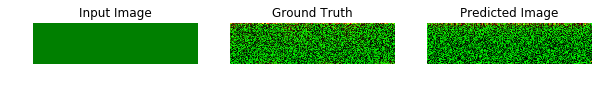

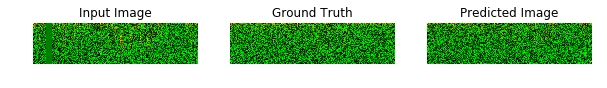

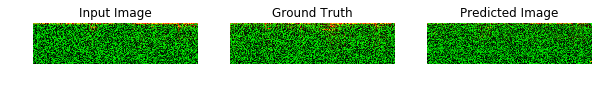

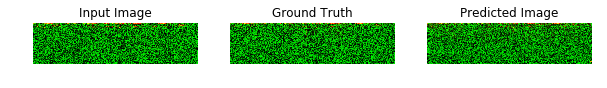

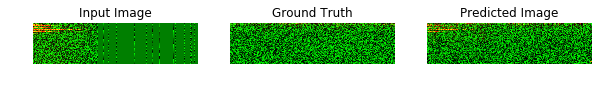

In [0]:
# Run the trained model on the entire test dataset
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)
